In [1]:
#libraries
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
from keras import backend as K
import cv2
import os
import numpy as np
import sys
import csv
import glob
import time
from sklearn.utils import shuffle
from keras.optimizers import Adam,rmsprop
from keras.models import model_from_json, load_model
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.layers import Convolution2D as Conv2D
from keras.layers.convolutional import Deconv2D as Conv2DTranspose
from keras.layers import Lambda, Input, Dense, MaxPooling2D, BatchNormalization,Input
from keras.layers import UpSampling2D, Dropout, Flatten, Reshape, RepeatVector, LeakyReLU,Activation
from keras.callbacks import ModelCheckpoint
from keras.losses import mse, binary_crossentropy
from keras.callbacks import EarlyStopping
np.random.seed(7)
from keras.callbacks import CSVLogger
from keras.callbacks import History 
import random
from itertools import product
import matplotlib.pyplot as plt
import prettytable
from prettytable import PrettyTable

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/gdrive/My Drive"

'A Decentralized Framework for Collision Free Multi-Robot Navigation.gslides'
'A Fog-Aware Adaptive Framework for Optimizing the Performance of Resource Constrained Self-driving Robots.gslides'
 AnomalyDetectionVAE
'Assurance Framework.pptx'
 Beta-VAE-New-Results.gslides
'B-VAE For Novelty Detection  .gslides'
 carla-different-weather.mp4
 carla-same-weather.mp4
'Car Supplies.gsheet'
'Change Point Detection for Perception Based Systems.gslides'
'Change Point Detection for Perception Based Systems.pptx'
'Colab Notebooks'
'Collaborators List-Dubey-FINAL.gsheet'
'Collaborators List-Dubey-FINAL.xlsx'
'DeepNNCar (1).gslides'
 DeepNNCar_2019
 DeepNNCar-Framework.gslides
 DeepNNCar.gslides
 DeepNNCar.pptx
'Designing Safety Cases for DeepNNCar.gdoc'
 DrawIO
'Emergency braking example.docx'
'Emergency braking example.gdoc'
'Experiment Section Carla.gdoc'
 frame3097.png
 Framework.gslides
'Framework to identify out-of-distribution images.gslides'
'Identifying Out-of distribution Images using VAE

In [0]:
!unzip "/content/gdrive/My Drive/sunny-train.zip" -d "/content/gdrive/My Drive/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/gdrive/My Drive/sunny-train/frame1337.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame1340.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame4.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame6.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame22.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame36.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame37.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame38.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame41.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame42.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame48.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame65.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame68.png  
  inflating: /content/gdrive/My Drive/sunny-train/frame73.png  
  inflating: /content/gdrive/My Drive/sunny-train/f

In [0]:
# path to USB
USBPath = "/content/gdrive/My Drive/"
trainingFolders = ["sunny-train"]
history = CSVLogger(USBPath + '/kerasloss.csv', append=True, separator=';')

#Load complete input images without shuffling
def load_images(paths):
    numImages = 0
    inputs = []
    for path in paths:
        numFiles = len(glob.glob1(path,'*.png'))
        numImages += numFiles
        for img in glob.glob(path+'*.png'):
            img = cv2.imread(img)
            img = cv2.resize(img, (200,66))
            img = img /255.
            inputs.append(img)
    #inpu = shuffle(inputs)
    print("Total number of images:%d" %(numImages))
    return inputs

def createFolderPaths(folders):
    paths = []
    for folder in folders:
        path = USBPath + folder + '/'
        paths.append(path)
    return paths

def load_training_images():
    paths = createFolderPaths(trainingFolders)
    return load_images(paths)

def load_steering_value():
    miny= -1
    maxy= 1
    Y=[]
    dataset = "/content/gdrive/My Drive/" + '/sunny-train.csv'
    with open(dataset, 'rt') as csvfile:
          reader = csv.reader(csvfile)
          for row in reader:
            output=[]
            x=(float(row[0])-miny)/(maxy-miny)
            output.append(x)
            Y.append(output)
    return Y        

In [0]:
#Loading images from the datasets
image_input = load_training_images()
steer_output = load_steering_value()
print("Total Steering values:%d"%len(steer_output))
image_input = np.array(image_input)
steer_output = np.array(steer_output)

In [0]:
#CNN-VAE model.
def createModel():

    model = Sequential()
    input= Input(shape=(66,200,3), name='image')
    steer_inp = BatchNormalization(epsilon=0.001, axis=-1,momentum=0.99)(input)
    layer1 = Conv2D(24, (5, 5), padding="valid", strides=(2, 2), activation="relu")(steer_inp)
    layer2 = Conv2D(36, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer1)
    layer3 = Conv2D(48, (5, 5), padding="valid", strides=(2, 2), activation="relu")(layer2)
    layer4 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu")(layer3)
    layer5 = Conv2D(64, (3, 3), padding="valid", strides=(1, 1), activation="relu")(layer4)
    layer6 = Flatten()(layer5)
    layer7 = Dense(1164, activation='relu')(layer6)
    layer8 = Dense(100, activation='relu')(layer7)
    layer9 = Dense(10, activation='relu')(layer8)
    steer_out = Dense(1, activation='tanh')(layer9)
    model=Model(inputs=input, outputs=steer_out)
  
    return model

#training the model with different hyperparameters
def trainModel(model, X, Y,e,b):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.05,random_state=42)
    adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss='mse', optimizer=adam, metrics=["MAE"])
    callbacks_list = [EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=0),]
    #ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)]
    hist=model.fit(X_train, Y_train, epochs=e, batch_size=b,validation_data=(X_test, Y_test),callbacks=callbacks_list, verbose=0)
    return hist

#function for arranging list in descending order
def takeFirst(elem):
    return elem[2]


In [0]:
def plot_results(rand_x,rand_y,epochs,batches,iterations):#Plot to analyze the state space sampling
        x_lims = [np.min(epochs), np.max(epochs)]
        y_lims = [np.min(batches), np.max(batches)]
        plt.scatter(rand_x, rand_y, c=['blue']*iterations)
        plt.gca().set(xlabel='epochs', ylabel='batch_size',title='Hyperparameters Search Space')
        plt.show()

def hyperparameter_search(trial,iterations,epochs,batches):
    selection=[]
    loss = []
    rand_x = []
    rand_y = []
    model = createModel()# create model
    
    if(trial == "random"):#random search
        time1=time.time()
        combinations_list = [list(x) for x in product(epochs, batches)]
        random_combinations_index = np.random.choice(range(0,len(combinations_list)), iterations, replace=False)
        combinations_random_chosen = [combinations_list[x] for x in random_combinations_index]
        print(combinations_random_chosen)#printing chosen random combination
        for i in range(iterations):
            rand_x.append(combinations_random_chosen[i][0])
            rand_y.append(combinations_random_chosen[i][1])
            print("**********************epoch=%d,batch=%d*********************"%(combinations_random_chosen[i][0],combinations_random_chosen[i][1]))
            loss_val=trainModel(model, image_input, steer_output, combinations_random_chosen[i][0], combinations_random_chosen[i][1])#train model with new hyperparameters
            loss.append((combinations_random_chosen[i][0],combinations_random_chosen[i][1], loss_val.history['loss'][-1]))#extract and append loss from last epoch
            loss.sort(key=takeFirst,reverse=False)#sort list to get the hyperparameters resulting in least loss
            print(loss[0])
            selection.append(loss[0])
        print("Tuning Time=%f"%(time.time()-time1))
        selection.sort(key=takeFirst,reverse=False)
        t = PrettyTable(['Epoch','Batch_size','Loss'])#print results in Table
        for values in selection:
            t.add_row([values[0],values[1],values[2]])
        print(t)
        print("******The selected hyperparameters and loss are******")
        print("Batch_size=%d Epochs=%d loss=%f"%(selection[0][0],selection[0][1],selection[0][2]))
        
        plot_results(rand_x,rand_y,epochs,batches,iterations)#Plot to analyze the hyperparameter combination
        

    if(trial == "grid"):#grid search
        time1=time.time()
        combinations_list = [list(x) for x in product(epochs, batches)]
        for combinations_random_chosen in (combinations_list):
            rand_x.append(combinations_random_chosen[0])
            rand_y.append(combinations_random_chosen[1])
            print("**********************epoch=%d,batch=%d*********************"%(combinations_random_chosen[0],combinations_random_chosen[1]))
            loss_val=trainModel(model, image_input, steer_output, combinations_random_chosen[0], combinations_random_chosen[1])#train model with new hyperparameters
            loss.append((combinations_random_chosen[0],combinations_random_chosen[1], loss_val.history['loss'][-1]))#extract and append loss from last epoch
            loss.sort(key=takeFirst,reverse=False)#sort list to get the hyperparameters resulting in least loss
            print(loss[0])
            selection.append(loss[0])
        print("Tuning Time=%f"%(time.time()-time1))
        selection.sort(key=takeFirst,reverse=False)
        t = PrettyTable(['Epoch','Batch_size','Loss'])#print results in Table
        for values in selection:
            t.add_row([values[0],values[1],values[2]])
        print(t)
        print("******The selected hyperparameters and loss are******")
        print("Batch_size=%d Epochs=%d loss=%f"%(selection[0][0],selection[0][1],selection[0][2]))
        
        plot_results(rand_x,rand_y,epochs,batches,len(combinations_list))#Plot to analyze the hyperparameter combination
        












[[1, 32], [2, 32]]
**********************epoch=1,batch=32*********************



(1, 32, 0.00772928952624171)
**********************epoch=2,batch=32*********************
(2, 32, 0.0013986358726069655)
Tuning Time=17.313164
+-------+------------+-----------------------+
| Epoch | Batch_size |          Loss         |
+-------+------------+-----------------------+
|   2   |     32     | 0.0013986358726069655 |
|   1   |     32     |  0.00772928952624171  |
+-------+------------+-----------------------+
******The selected hyperparameters and loss are******
Batch_size=2 Epochs=32 loss=0.001399


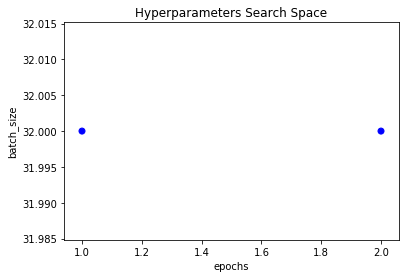

In [0]:
epochs = [1,2,4]#hyperparameter1
batches = [16,32]#hyperparameter2
trial = "random" #choose what kind of hyperparameter selection algorithm to use
iterations = 2 #For random search select how many random samples have to be chosen
hyperparameter_search(trial,iterations,epochs,batches)# call the hyperparameter tuning function